In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model
from collections import deque

Using TensorFlow backend.


## DQN Implementation

In [2]:
# class object for Deep Q-Learning
class DQN:
    def __init__(self, env, gamma = 0.99, lr = 5e-4, tau = 1e-3):
        # init environment
        self.env = env
        
        # Init replay buffer
        # Use deque for its property of auto-discarding stored elements if it is full
        self.replay_buffer  = deque(maxlen=int(1e5))
        
        # define discount rate gamma
        # learning rate lr for keras gradient descent
        # tau for soft-update
        self.gamma = gamma
        self.lr = lr
        self.tau = tau 
        
        # construct model for action-value function
        # construct target_model for target action-value function
        # target model is used to generate value estimate and make action selection
        # model is learning from experience and improve estimate
        self.model, self.target_model  = self.init_model(), self.init_model()
        
        # Every C step soft update target model Q_hat to model Q
        self.C = 4
        
        # batch size in learning
        self.batch_size = 64
        
        # Counter
        self.t = 0
    
    # create keras NN model
    def init_model(self):
        # set input and output shape
        # input shape is the dimension of state space (8,1)
        # output shape is the dimension of actions (4,1)
        input_shape = self.env.observation_space.shape[0]
        output_shape = self.env.action_space.n
        
        # Define Sequential model (linear stack of layers)  
        # Add hidden layers: two hidden layers with the size of 64
        model = Sequential()        
        model.add(Dense(64, input_dim=input_shape, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(output_shape))
        
        # Define the loss function of mse, Use Adam for optimization
        model.compile(loss="mean_squared_error",optimizer=Adam(lr=self.lr))
        
        return model
    
    # Store transition to replay buffer
    def add_to_buffer(self, state, action, reward, new_state, done):
        self.replay_buffer.append([state, action, reward, new_state, done])
    
    # Take action with epsilon-greedy respect to action-value function prediction from model
    def generate_action(self, state, eps):
        # epsilon-greey to take best action from action-value function
        if np.random.random() < eps:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])
    
    # soft update to target model Q_hat from model Q
    def train_target(self):
        # target model and model are not updating at the same time
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * weights[i] + (1 - self.tau) * target_weights[i]
        # assign new weights to target model
        self.target_model.set_weights(target_weights)

    # the batch learning (gradient descent) of the model Q
    def learning(self):
        self.t = (self.t + 1) % self.C
        
        # update every C times and make sure buffer is filled with at least size batch size
        if self.t == 0:
            if len(self.replay_buffer) < self.batch_size: 
                return
            
            # init list states to store states 
            # init list of targets values forecast gernated by model Q associated with each state-action
            states, targets_forecast = [], []
            
            # random sample from replay buffer
            samples = random.sample(self.replay_buffer, self.batch_size)
            
            for state, action, reward, new_state, done in samples:
                if done:
                    target = reward
                else:
                    Q_new_state =  np.amax(self.target_model.predict(new_state)[0])
                    target = reward + self.gamma *  Q_new_state

                target_forecast = self.model.predict(state)
                target_forecast[0][action] = target
                
                # append to lists for batch processing outside the iteartion
                states.append(state[0])
                targets_forecast.append(target_forecast[0])
            
            # batch learning to train the model Q   
            self.model.fit(np.array(states), np.array(targets_forecast), epochs=1, verbose=0)
            self.train_target()
    
    # save complete model
    def save_model(self, fn):
        self.model.save(fn)

In [3]:
# Function for training
def train(gamma = 0.99, lr = 5e-4, tau = 1e-3, epsilon_decay = 0.995):
    env = gym.make("LunarLander-v2")
    
    # Define the epsilon and its decay for epsilon-greedy action selection
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = epsilon_decay
    
    # Define no.of training episodes and max steps for each episode
    episodes  = 1000
    steps = 500

    # scores store all score in each trial
    # scores_window stores last 100 trial scores
    scores = []                        
    scores_window = deque(maxlen=100)
    
    # epsilons store all epsilon values:
    epsilons = []
    
    # init the DQN agent
    agent = DQN(env=env, gamma=gamma, lr=lr, tau=tau)
    
    # each trial
    for trial in range(episodes):
        score = 0
        cur_state = env.reset().reshape(1,8)
        epsilons.append(epsilon)
        
        # each step in an training trial/episode
        for step in range(steps):
            #env.render()
            
            # get action from agent and take that action
            action = agent.generate_action(cur_state ,epsilon)
            new_state, reward, done, _ = env.step(action)
            score += reward
            new_state = new_state.reshape(1,8)
            
            # add experience to replay buffer
            agent.add_to_buffer(cur_state, action, reward, new_state, done)
            
            # learning from current step
            agent.learning()
            cur_state = new_state
        
            if done:
                break   
        
        scores.append(score)
        scores_window.append(score)
        
        # decay of epsilon, in early training, perform more exploration
        # at later stage of training, perform more exploitation
        epsilon *= epsilon_decay
        epsilon = max(epsilon_min, epsilon)
        
        print('\rtrial {}\t Mean Score: {:.3f} \t with epsilon: {:.3f}'.format(trial, np.mean(scores_window), epsilon), end="")
        
        if trial % 100 == 0:
            print('\rtrial {}\t Mean Score: {:.3f}'.format(trial, np.mean(scores_window)))
        
        # stop if last 100 consecutive scores, save the model/agent
        if np.mean(scores_window)>=200.0:
            #agent.save_model("dqn_model.h5")
            print('\n Achieve Mean Score of 200 for past 100 trials with total {:d} trial!\tAverage Score: {:.3f}'.format(trial-100, np.mean(scores_window)))
            break                     
    
    env.close()
    return (scores,epsilons)





In [4]:
def plot_values(values, xlabel, ylabel):
    fig = plt.figure()
    plt.plot(np.arange(len(values)), values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [5]:
scores_epsilon_decay = {}
epsilons_epsilon_decay = {}

In [6]:
epsilon_decays = [0.8, 0.9, 0.99, 0.995, 1]

In [7]:
for epsilon_decay in  epsilon_decays:
    print("Epsilon Decay Ratio: {:.3f}\n".format(epsilon_decay), end="")
    scores_epsilon_decay[epsilon_decay], epsilons_epsilon_decay[epsilon_decay] = train(epsilon_decay=epsilon_decay)
    

Epsilon Decay Ratio: 0.800
trial 0	 Mean Score: -70.613 	 with epsilon: 0.800
trial 100	 Mean Score: -221.160 	 with epsilon: 0.010
trial 200	 Mean Score: -43.831 	 with epsilon: 0.0100
trial 300	 Mean Score: -26.366 	 with epsilon: 0.010
trial 400	 Mean Score: -33.772 	 with epsilon: 0.010
trial 500	 Mean Score: -36.628 	 with epsilon: 0.010
trial 600	 Mean Score: -31.212 	 with epsilon: 0.010
trial 700	 Mean Score: 6.946 	 with epsilon: 0.01000
trial 800	 Mean Score: 39.855 	 with epsilon: 0.010
trial 900	 Mean Score: 44.079 	 with epsilon: 0.010
trial 999	 Mean Score: 17.435 	 with epsilon: 0.010Epsilon Decay Ratio: 0.900
trial 0	 Mean Score: -90.170 	 with epsilon: 0.900
trial 100	 Mean Score: -181.945 	 with epsilon: 0.010
trial 200	 Mean Score: -47.002 	 with epsilon: 0.0100
trial 300	 Mean Score: -19.501 	 with epsilon: 0.010
trial 400	 Mean Score: -2.678 	 with epsilon: 0.0100
trial 500	 Mean Score: 50.055 	 with epsilon: 0.010
trial 600	 Mean Score: 60.791 	 with epsilon: 0.01

In [8]:
import pickle
pickle.dump(scores_epsilon_decay, open("scores_epsilon_decay.p", "wb"))
pickle.dump(epsilons_epsilon_decay, open("epsilons_epsilon_decay.p", "wb"))

In [14]:
import pandas as pd
scores_epsilon_decay_pd = pd.DataFrame(list(scores_epsilon_decay[0.8]), columns = ["epsilon_decay="+str(0.8)])

for epsilon_decay in epsilon_decays[1:]:
    df = pd.DataFrame(list(scores_epsilon_decay[epsilon_decay]), columns = ["epsilon_decay="+str(epsilon_decay)])
    scores_epsilon_decay_pd = pd.concat([scores_epsilon_decay_pd, df], axis = 1)
    
scores_epsilon_decay_pd['Trials'] = np.arange(scores_epsilon_decay_pd.shape[0])  
scores_epsilon_decay_pd

,epsilon_decay=0.8,epsilon_decay=0.9,epsilon_decay=0.99,epsilon_decay=0.995,epsilon_decay=1,Trials
0,-70.612594,-90.170410,-95.510371,-113.515501,-126.631272,0
1,-54.578420,-92.023639,-187.106565,-426.281353,-84.122545,1
2,-610.255309,-49.441095,-231.507280,-176.591134,-283.023026,2
3,-366.345362,-374.079862,-381.484878,-279.918175,-293.858227,3
4,-92.496001,-426.763120,-289.739282,-145.277182,-127.684972,4
5,-275.067001,-458.427302,-92.907935,-179.720866,-209.145538,5
6,-185.896378,-439.585746,-135.819406,8.936837,-289.316436,6
7,-144.562839,-216.781432,-113.826041,-359.820160,-324.734580,7
8,-236.330928,-151.049699,-70.405349,-103.381945,-121.536003,8
9,-394.031215,-50.819234,-84.325762,-512.158210,-84.271911,9


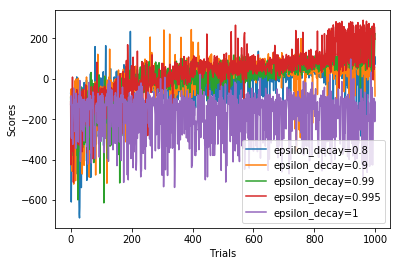

In [15]:
plt.plot("Trials","epsilon_decay=0.8", data=scores_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=0.9", data=scores_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=0.99", data=scores_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=0.995", data=scores_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=1", data=scores_epsilon_decay_pd)
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()

In [16]:
epsilons_epsilon_decay_pd = pd.DataFrame(list(epsilons_epsilon_decay[0.8]), columns = ["epsilon_decay="+str(0.8)])

for epsilon_decay in epsilon_decays[1:]:
    df = pd.DataFrame(list(epsilons_epsilon_decay[epsilon_decay]), columns = ["epsilon_decay="+str(epsilon_decay)])
    epsilons_epsilon_decay_pd = pd.concat([epsilons_epsilon_decay_pd, df], axis = 1)
    
epsilons_epsilon_decay_pd['Trials'] = np.arange(epsilons_epsilon_decay_pd.shape[0])  
epsilons_epsilon_decay_pd

,epsilon_decay=0.8,epsilon_decay=0.9,epsilon_decay=0.99,epsilon_decay=0.995,epsilon_decay=1,Trials
0,1.000000,1.000000,1.000000,1.000000,1.0,0
1,0.800000,0.900000,0.990000,0.995000,1.0,1
2,0.640000,0.810000,0.980100,0.990025,1.0,2
3,0.512000,0.729000,0.970299,0.985075,1.0,3
4,0.409600,0.656100,0.960596,0.980150,1.0,4
5,0.327680,0.590490,0.950990,0.975249,1.0,5
6,0.262144,0.531441,0.941480,0.970373,1.0,6
7,0.209715,0.478297,0.932065,0.965521,1.0,7
8,0.167772,0.430467,0.922745,0.960693,1.0,8
9,0.134218,0.387420,0.913517,0.955890,1.0,9


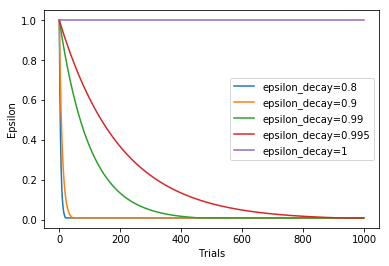

In [18]:
plt.plot("Trials","epsilon_decay=0.8", data=epsilons_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=0.9", data=epsilons_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=0.99", data=epsilons_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=0.995", data=epsilons_epsilon_decay_pd)
plt.plot("Trials","epsilon_decay=1", data=epsilons_epsilon_decay_pd)
plt.legend()
plt.ylabel("Epsilon")
plt.xlabel("Trials")
plt.show()